# 4.3 - Train a model for each dataset category, comparing it to random data

In [20]:
import os
import sys
import datetime
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

import models
import report
import block_sampler
import batch_encoder
from dataset import Dataset
from report import Reporter2
from trainer import Trainer, TrainResults
from batch_encoder import Dataset, one_hot
from block_sampler import count_sectors, BlockSamplerByFile, RandomSampler
from batch_encoder import xs_encoder_8bits_11, BatchEncoder, xs_encoder_one_hot
from filter_random import gen_rndchk_models, evaluate_rnd_model, filter_dataset

from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Activation, TimeDistributed, Flatten, Dot, Softmax, Lambda, RepeatVector, Multiply, Permute, Reshape, BatchNormalization

In [2]:
raw_dataset_folder='sample200'
minimum=200
maximum=200
result_dir = 'results/4.3-randomness'
os.makedirs(result_dir, exist_ok=True)

In [3]:
rawset = Dataset.new_from_folders(raw_dataset_folder).filter_min_max(minimum, maximum)
rawset = rawset.filter(lambda x: rawset.category_from(x) not in ['text', 'unk'])
rawset.rebuild_categories()
rawtset, rawvset = rawset.rnd_split_fraction_by_category(0.5)

In [4]:
class CatSampler:
    def __init__(self, model, blksampler, cat):
        self.model = model
        self.blksampler = blksampler
        self.dataset = blksampler.dataset
        self.cat = cat

    def __iter__(self):
        fails=0
        tbenc = iter(BatchEncoder(self.blksampler, 100,
                                  xs_encoder='one_hot'))
        while True:
            blks = next(tbenc)[0]
            predict = self.model.predict(blks)
            predict = np.argmax(predict, axis=-1)
            blks = [x for x,y in zip(blks, predict) if y == self.cat]
            if len(blks) == 0:
                fails += 1
                if fails > 1000:
                    raise Exception("all blocks seems to be the wrong kind")
                continue
            fails=0
            for blk in blks:
                yield block_sampler.BlockInstance(np.argmax(blk, axis=-1), self.blksampler.dataset.categories[self.cat])


In [5]:
class ThrSampler:
    def __init__(self, model, blksampler, threshold, cat):
        self.model = model
        self.blksampler = blksampler
        self.dataset = blksampler.dataset
        self.threshold = threshold
        self.cat = cat

    def __iter__(self):
        fails=0
        tbenc = iter(BatchEncoder(self.blksampler, 100,
                                  xs_encoder='one_hot'))
        while True:
            blks = next(tbenc)[0]
            predict = self.model.predict(blks)
            predict = predict[:,0]-predict[:,1]
            blks = [x for x,y in zip(blks, predict) if y > self.threshold]
            if len(blks) == 0:
                fails += 1
                if fails > 1000:
                    raise Exception("all blocks seems to be the wrong kind")
                continue
            fails=0
            for blk in blks:
                yield block_sampler.BlockInstance(np.argmax(blk, axis=-1), self.cat)


In [9]:
steps_per_epoch=28
patience=10

In [10]:
import models
from block_sampler import BlockSamplerByCategory
from batch_encoder import BatchEncoder
from collections import namedtuple
import callbacks
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

TrainResults = namedtuple(
    'TrainResults', ['model', 'history', 'metrics', 'elapsed'])

class RandomTrainer:
    def __init__(self,
                 model,
                 xs_encoder='one_hot',
                 validation_steps=steps_per_epoch,
                 steps_per_epoch=steps_per_epoch,
                 epochs=10000000,
                 max_seconds=None,
                 batch_size=100,
                 min_delta=1e-03,
                 patience=patience):
        self.model = model
        self.xs_encoder = xs_encoder
        self.validation_steps = validation_steps
        self.steps_per_epoch = steps_per_epoch
        self.epochs = epochs
        self.max_seconds = max_seconds
        self.batch_size = batch_size
        self.min_delta = min_delta
        self.patience = patience

    def train(self, tset, vset, previous_model=None, previous_model2=None):
        tsampler = BlockSamplerByFile(tset)
        if previous_model:
            tsampler = CatSampler(previous_model, tsampler, 0)
        if previous_model2:
            tsampler = CatSampler(previous_model2, tsampler, 0)
        trsampler = RandomSampler(tsampler, rnd_cat='zzz', not_rnd_cat=tset.categories[0])
        tbenc = BatchEncoder(trsampler, self.batch_size,
                             xs_encoder=self.xs_encoder)

        vsampler = BlockSamplerByFile(vset)
        if previous_model:
            vsampler = CatSampler(previous_model, vsampler, 0)
        if previous_model2:
            vsampler = CatSampler(previous_model2, vsampler, 0)
        vrsampler = RandomSampler(vsampler, rnd_cat='zzz', not_rnd_cat=vset.categories[0])
        vbenc = BatchEncoder(vrsampler, self.batch_size,
                             xs_encoder=self.xs_encoder)

        return self._train(tbenc,vbenc)

    def _train(self, tbenc, vbenc):
        model = self.model

        timeIt = callbacks.TimeIt()

        history = model.fit_generator(iter(tbenc),
                                      validation_data=iter(vbenc),
                                      validation_steps=self.validation_steps,
                                      steps_per_epoch=self.steps_per_epoch,
                                      epochs=self.epochs,
                                      verbose=0,
                                      callbacks=[
            timeIt,
            # callbacks.SaveModel(os.path.join(result_dir, model.name + '.h5')),
#             callbacks.TimeLimit(self.max_seconds),
            EarlyStopping(monitor='val_categorical_accuracy',
                          min_delta=self.min_delta, patience=self.patience),
            # TensorBoard(
            #     log_dir=os.path.join(log_dir, model.name),
            #     # update_freq=3100,
            # ),
#             LambdaCallback(on_epoch_end = lambda epoch, logs: print(logs['val_categorical_accuracy'])),
        ],
            use_multiprocessing=False,
            workers=0,
        )
        return TrainResults(
            model=model,
            history=history,
            metrics=['val_binary_accuracy', 'val_categorical_accuracy'],
            elapsed=timeIt.elapsed,
        )

# Train until 98%

In [ ]:
def CLD(classes, len_byte_vector):
    last = l0 = Input(shape=(512,len_byte_vector))
    last = Conv1D(256, (16,), strides=16)(last)
    last = LSTM(128)(last)
    last = Dense(classes)(last)
    last = Activation('softmax')(last)
    name = sys._getframe().f_code.co_name
    model = tf.keras.Model([l0], last, name=name)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['binary_accuracy', 'categorical_accuracy'])
    return model

In [13]:
by_categoryT = rawtset.by_category()
by_categoryV = rawvset.by_category()
cat='dwf'
threshold = 0
batch_size = 100
model_pass={}
for npass in [1, 2, 3, 4, 5]:
    tset = by_categoryT[cat]
    vset = by_categoryV[cat]
    tset.rebuild_categories(categories=[cat, 'zzz'])
    vset.rebuild_categories(categories=[cat, 'zzz'])
    model = CLD(2, 256)
    print(cat)
    tsampler = BlockSamplerByFile(tset)
    for n in range(1, npass):
        previous_model = model_pass[n]
        tsampler = ThrSampler(previous_model, tsampler, threshold, cat)
    tsampler = RandomSampler(tsampler, rnd_cat='zzz', not_rnd_cat=cat)
    tbenc = BatchEncoder(tsampler, batch_size,
                         xs_encoder='one_hot')

    vsampler = BlockSamplerByFile(vset)
    for n in range(1, npass):
        previous_model = model_pass[n]
        vsampler = ThrSampler(previous_model, vsampler, threshold, cat)
    vsampler = RandomSampler(vsampler, rnd_cat='zzz', not_rnd_cat=vset.categories[0])
    vbenc = BatchEncoder(vsampler, batch_size,
                         xs_encoder='one_hot')

    result = RandomTrainer(
        model,
        batch_size=100,
        steps_per_epoch=steps_per_epoch,
        validation_steps=steps_per_epoch,
        patience=patience,
    )._train(tbenc,vbenc)
    val_acc = result.history.history['val_categorical_accuracy'][-1]
    print('val_acc =', val_acc)
    model_pass[npass]=model
    if val_acc > 0.98:
        break

dwf
val_acc = 0.7207143
dwf
val_acc = 0.895
dwf
val_acc = 0.9439286
dwf
val_acc = 0.9667857
dwf
val_acc = 0.98285717


In [21]:
def CM(classes, len_byte_vector):
    last = l0 = Input(shape=(512,len_byte_vector))
    last = Conv1D(classes, (32,), strides=1)(last)
    last = MaxPooling1D(pool_size=481, strides=1)(last)
    last = Flatten()(last)
    last = Activation('softmax')(last)
    name = sys._getframe().f_code.co_name
    model = tf.keras.Model([l0], last, name=name)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['binary_accuracy', 'categorical_accuracy'])
    return model

In [27]:
by_categoryT = rawtset.by_category()
by_categoryV = rawvset.by_category()
cat='dwf'
threshold = 0.5
batch_size = 100
model_pass={}
for npass in [1, 2, 3, 4, 5]:
    tset = by_categoryT[cat]
    vset = by_categoryV[cat]
    tset.rebuild_categories(categories=[cat, 'zzz'])
    vset.rebuild_categories(categories=[cat, 'zzz'])
    model = CM(2, 256)
    print(cat)
    tsampler = BlockSamplerByFile(tset)
    for n in range(1, npass):
        previous_model = model_pass[n]
        tsampler = ThrSampler(previous_model, tsampler, threshold, cat)
    tsampler = RandomSampler(tsampler, rnd_cat='zzz', not_rnd_cat=cat)
    tbenc = BatchEncoder(tsampler, batch_size,
                         xs_encoder='one_hot')

    vsampler = BlockSamplerByFile(vset)
    for n in range(1, npass):
        previous_model = model_pass[n]
        vsampler = ThrSampler(previous_model, vsampler, threshold, cat)
    vsampler = RandomSampler(vsampler, rnd_cat='zzz', not_rnd_cat=vset.categories[0])
    vbenc = BatchEncoder(vsampler, batch_size,
                         xs_encoder='one_hot')

    result = RandomTrainer(
        model,
        batch_size=100,
        steps_per_epoch=steps_per_epoch,
        validation_steps=steps_per_epoch,
        patience=patience,
    )._train(tbenc,vbenc)
    val_acc = result.history.history['val_categorical_accuracy'][-1]
    print('val_acc =', val_acc)
    model_pass[npass]=model
    if val_acc > 0.98:
        break    

dwf
val_acc = 0.5642857
dwf
val_acc = 0.99964285


In [23]:
def CCM(classes, len_byte_vector):
    last = l0 = Input(shape=(512,len_byte_vector))
    last = Conv1D(classes, (32,), strides=1)(last)
    last = Conv1D(classes, (2,), strides=2)(last)
    last = MaxPooling1D(pool_size=240, strides=1)(last)
    last = Flatten()(last)
    last = Activation('softmax')(last)
    name = sys._getframe().f_code.co_name
    model = tf.keras.Model([l0], last, name=name)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['binary_accuracy', 'categorical_accuracy'])
    return model

In [24]:
by_categoryT = rawtset.by_category()
by_categoryV = rawvset.by_category()
cat='dwf'
threshold = 0
batch_size = 100
model_pass={}
for npass in [1, 2, 3, 4, 5]:
    tset = by_categoryT[cat]
    vset = by_categoryV[cat]
    tset.rebuild_categories(categories=[cat, 'zzz'])
    vset.rebuild_categories(categories=[cat, 'zzz'])
    model = models.C256_16_16_L128_D(
        2, 256, 'softmax', 'categorical_crossentropy')
    print(cat)
    tsampler = BlockSamplerByFile(tset)
    for n in range(1, npass):
        previous_model = model_pass[n]
        tsampler = ThrSampler(previous_model, tsampler, threshold, cat)
    tsampler = RandomSampler(tsampler, rnd_cat='zzz', not_rnd_cat=cat)
    tbenc = BatchEncoder(tsampler, batch_size,
                         xs_encoder='one_hot')

    vsampler = BlockSamplerByFile(vset)
    for n in range(1, npass):
        previous_model = model_pass[n]
        vsampler = ThrSampler(previous_model, vsampler, threshold, cat)
    vsampler = RandomSampler(vsampler, rnd_cat='zzz', not_rnd_cat=vset.categories[0])
    vbenc = BatchEncoder(vsampler, batch_size,
                         xs_encoder='one_hot')

    result = RandomTrainer(
        model,
        batch_size=100,
        steps_per_epoch=steps_per_epoch,
        validation_steps=steps_per_epoch,
        patience=patience,
    )._train(tbenc,vbenc)
    val_acc = result.history.history['val_categorical_accuracy'][-1]
    print('val_acc =', val_acc)
    model_pass[npass]=model
    if val_acc > 0.98:
        break

dwf
val_acc = 0.7146429
dwf
val_acc = 0.88464284
dwf


KeyboardInterrupt: 

# Train pass1 models

In [ ]:
r = Reporter2(result_dir + "/pass1.tsv")
by_categoryT = rawtset.by_category()
by_categoryV = rawvset.by_category()
for cat in ['dwf']:#by_categoryT.keys():
    tset = by_categoryT[cat]
    vset = by_categoryV[cat]
    tset.rebuild_categories(categories=[cat, 'zzz'])
    vset.rebuild_categories(categories=[cat, 'zzz'])
    model = models.C256_16_16_L128_D(
        2, 256, 'softmax', 'categorical_crossentropy')
    print(cat)
    result = RandomTrainer(
        model,
        batch_size=100,
        steps_per_epoch=28,
        validation_steps=28,
        patience=10,
    ).train(tset, vset)
    val_acc = result.history.history['val_categorical_accuracy'][-1]
    print('val_acc =', val_acc)
    r.line(category=cat,
           val_acc=val_acc,
           **report.report_elapsed(**result._asdict()),
           **report.report_epochs(**result._asdict()),
          )
    h5_path = os.path.join(result_dir, '%s_pass1.h5' % cat)
    tf.keras.Model.save(model, h5_path)
r.close()

# Load data

In [7]:
data = pd.read_csv(result_dir + '/pass1.tsv', sep='\t')
data = data.sort_values('val_acc')
data

,category,val_acc,Time,Epochs
8,dwf,0.709643,6m53s,28
18,gz,0.753571,8m14s,33
22,swf,0.770000,9m24s,41
12,kmz,0.781786,11m06s,45
27,pdf,0.818929,14m03s,62
24,png,0.825000,14m22s,64
17,pps,0.862500,16m06s,57
21,gif,0.868214,8m36s,35
0,pptx,0.871071,18m33s,68
16,ppt,0.898214,19m39s,67


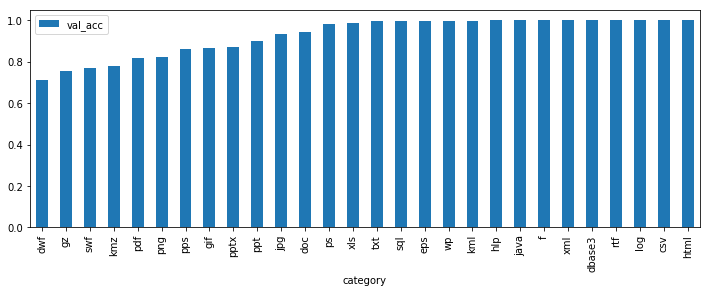

In [8]:
data.plot.bar('category', ['val_acc'], figsize=(12,4))
plt.show()

# Train pass2 models

In [ ]:
# if os.path.exists(result_dir + "/pass2.tsv"):
#     os.remove(result_dir + "/pass2.tsv")
# r = Reporter2(result_dir + "/pass2.tsv")
by_categoryT = rawtset.by_category()
by_categoryV = rawvset.by_category()
cat='dwf'
previous_model = tf.keras.models.load_model(result_dir + '/%s_pass1.h5' % cat)
for threshold in [0,0.5, 0.75, 0.8, 0.9]:
# for cat in by_categoryT.keys():
    tset = by_categoryT[cat]
    vset = by_categoryV[cat]
    tset.rebuild_categories(categories=[cat, 'zzz'])
    vset.rebuild_categories(categories=[cat, 'zzz'])
    if data.set_index('category').loc[cat].val_acc > 0.98:
        continue
#     previous_model = tf.keras.models.load_model(result_dir + '/%s_pass1.h5' % cat)
    model = models.C256_16_16_L128_D(
        2, 256, 'softmax', 'categorical_crossentropy')
    print(cat)
    batch_size = 100
    tsampler = BlockSamplerByFile(tset)
    tsampler = ThrSampler(previous_model, tsampler, threshold, cat)
    tsampler = RandomSampler(tsampler, rnd_cat='zzz', not_rnd_cat=tset.categories[0])
    tbenc = BatchEncoder(tsampler, batch_size,
                         xs_encoder='one_hot')

    vsampler = BlockSamplerByFile(vset)
    vsampler = ThrSampler(previous_model, vsampler, threshold, cat)
    vsampler = RandomSampler(vsampler, rnd_cat='zzz', not_rnd_cat=vset.categories[0])
    vbenc = BatchEncoder(vsampler, batch_size,
                         xs_encoder='one_hot')

    result = RandomTrainer(
        model,
        batch_size=100,
        steps_per_epoch=steps_per_epoch,
        validation_steps=steps_per_epoch,
        patience=patience,
    )._train(tbenc,vbenc)
    val_acc = result.history.history['val_categorical_accuracy'][-1]
    print('val_acc =', val_acc)
#     r.line(category=cat,
#            val_acc=val_acc,
#            **report.report_elapsed(**result._asdict()),
#            **report.report_epochs(**result._asdict()),
#           )
#     h5_path = os.path.join(result_dir, '%s_pass2.h5' % cat)
#     tf.keras.Model.save(model, h5_path)
# r.close()

dwf
val_acc = 0.8889286
dwf
val_acc = 0.895
dwf
val_acc = 0.93607146
dwf
val_acc = 0.93214285
dwf


In [120]:
if os.path.exists(result_dir + "/pass2.tsv"):
    os.remove(result_dir + "/pass2.tsv")
r = Reporter2(result_dir + "/pass2.tsv")
by_categoryT = rawtset.by_category()
by_categoryV = rawvset.by_category()
for cat in by_categoryT.keys():
    tset = by_categoryT[cat]
    vset = by_categoryV[cat]
    tset.rebuild_categories(categories=[cat, 'zzz'])
    vset.rebuild_categories(categories=[cat, 'zzz'])
    if data.set_index('category').loc[cat].val_acc > 0.98:
        continue
    previous_model = tf.keras.models.load_model(result_dir + '/%s_pass1.h5' % cat)
    previous_model._make_predict_function()
    model = models.C256_16_16_L128_D(
        2, 256, 'softmax', 'categorical_crossentropy')
    print(cat)
    threshold = 0
    batch_size = 100
    tsampler = BlockSamplerByFile(tset)
    tsampler = ThrSampler(previous_model, tsampler, threshold, cat)
    tsampler = RandomSampler(tsampler, rnd_cat='zzz', not_rnd_cat=tset.categories[0])
    tbenc = BatchEncoder(tsampler, batch_size,
                         xs_encoder='one_hot')

    vsampler = BlockSamplerByFile(vset)
    vsampler = ThrSampler(previous_model, vsampler, threshold, cat)
    vsampler = RandomSampler(vsampler, rnd_cat='zzz', not_rnd_cat=vset.categories[0])
    vbenc = BatchEncoder(vsampler, batch_size,
                         xs_encoder='one_hot')

    result = RandomTrainer(
        model,
        batch_size=100,
        steps_per_epoch=steps_per_epoch,
        validation_steps=steps_per_epoch,
        patience=patience,
    )._train(tbenc,vbenc)
    val_acc = result.history.history['val_categorical_accuracy'][-1]
    print('val_acc =', val_acc)
    r.line(category=cat,
           val_acc=val_acc,
           **report.report_elapsed(**result._asdict()),
           **report.report_epochs(**result._asdict()),
          )
    h5_path = os.path.join(result_dir, '%s_pass2.h5' % cat)
    tf.keras.Model.save(model, h5_path)
r.close()

dwf
val_acc = 0.8439286
pdf
val_acc = 0.9260714
pps
val_acc = 0.9317857
gz
val_acc = 0.8782143
jpg
val_acc = 0.9628571
pptx
val_acc = 0.95785713
doc
val_acc = 0.96
ppt
val_acc = 0.9432143
kmz
val_acc = 0.8371429
swf
val_acc = 0.9075
png
val_acc = 0.85
gif
val_acc = 0.93642855


# Load pass2 data

In [ ]:
data2 = pd.read_csv(result_dir + "/pass2.tsv", sep='\t')
data2 = data2.sort_values('val_acc')
data2

In [ ]:
data2.plot.bar('category', ['val_acc'], figsize=(12,4))
plt.show()

data3 = pd.read_csv(result_dir + "/pass3.tsv", sep='\t')
data3 = data3.sort_values('val_acc')
data3

# Use models to evaluate dataset

In [12]:
def rndgen():
    while True:
        rdata = np.random.randint(0, 256, (100,512), dtype='int')
        rdata = one_hot(rdata, 256)
        yield rdata

In [13]:
r = Reporter2(result_dir + "/evaluate.tsv")
by_category = rawset.by_category()
for cat, dataset in by_category.items():
    model = tf.keras.models.load_model(result_dir + '/%s_pass1.h5' % cat)
    tsampler = BlockSamplerByFile(dataset)
    tbenc = BatchEncoder(tsampler,
                         batch_size=1000,
                         xs_encoder='one_hot')
    xs, _ = next(iter(tbenc))
    datalen = len(xs)
    predict = model.predict(xs, batch_size=100)
    predict = np.argmax(predict, axis=-1)   
    not_random = len(predict[predict==0])/datalen
    
    predict = model.predict_generator(rndgen(), steps=10)
    predict = np.argmax(predict, axis=-1)   
    random = len(predict[predict==1])/datalen
    
    true_not_random = not_random - (1-not_random)*(1-random)/random
    
    print(cat, not_random, random, true_not_random )
    r.line(cat=cat, not_random=not_random, random=random, true_not_random=true_not_random)
r.close()

pptx 0.79 0.97 0.7835051546391752
java 1.0 1.0 1.0
doc 0.929 0.982 0.9276985743380856
csv 1.0 1.0 1.0
xml 1.0 1.0 1.0
wp 0.999 1.0 0.999
ps 0.98 1.0 0.98
kml 0.996 1.0 0.996
dwf 0.653 0.913 0.619934282584885
hlp 1.0 1.0 1.0
log 1.0 1.0 1.0
txt 0.995 1.0 0.995
kmz 0.723 0.99 0.7202020202020202
html 1.0 1.0 1.0
sql 0.997 1.0 0.997
eps 0.999 1.0 0.999
ppt 0.89 0.941 0.8831030818278427
pps 0.83 0.948 0.820675105485232
gz 0.724 0.856 0.6775700934579438
jpg 0.918 0.984 0.9166666666666667
dbase3 1.0 1.0 1.0
gif 0.863 0.991 0.8617558022199798
swf 0.634 0.962 0.6195426195426196
f 1.0 1.0 1.0
png 0.826 0.948 0.8164556962025316
xls 0.985 1.0 0.985
rtf 1.0 1.0 1.0
pdf 0.757 0.972 0.75


# Load evaluation data

In [14]:
data3 = pd.read_csv(result_dir + "/evaluate.tsv", sep='\t')
data3 = data3.sort_values('true_not_random')
data3

,cat,not_random,random,true_not_random
22,swf,0.634,0.962,0.619543
8,dwf,0.653,0.913,0.619934
18,gz,0.724,0.856,0.677570
12,kmz,0.723,0.990,0.720202
27,pdf,0.757,0.972,0.750000
0,pptx,0.790,0.970,0.783505
24,png,0.826,0.948,0.816456
17,pps,0.830,0.948,0.820675
21,gif,0.863,0.991,0.861756
16,ppt,0.890,0.941,0.883103


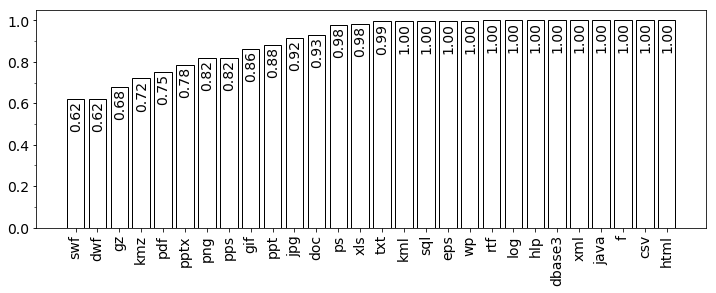

In [15]:
from matplotlib.ticker import MultipleLocator
fig, ax = plt.subplots(figsize=(12,4))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
# plt.grid(linestyle='--', which='minor')
ax.bar(data3['cat'], data3['true_not_random'], fill=False)
plt.xticks(rotation='vertical')
ax.tick_params(labelsize=14)
for i in range(28):
    cat = rawset.ix_to_cat[i]
    v = data3.iloc[i,3]
    t = ax.annotate('%0.2f'%v, (i-0.3, v-0.06),fontsize=14)
    t.set_rotation(90)
# data3.plot.bar('cat', ['not_random'], figsize=(12,4))
# plt.show()

In [16]:
data3.mean()

not_random         0.910286
random             0.980607
true_not_random    0.905290
dtype: float64

In [17]:
1-np.sum(data3['true_not_random'])/28

0.09471038938689347

In [ ]:
1-(np.sum(data3['true_not_random'])+(1-0.62))/28

# Roc pass1

In [19]:
from sklearn.metrics import roc_curve, auc

In [54]:
by_category = rawset.by_category()
cat = 'jpg'
dataset = by_category[cat]
dataset.rebuild_categories(categories=['jpg', 'zzz'])

model = tf.keras.models.load_model(result_dir + '/%s_pass1.h5' % cat)

In [56]:
tsampler = BlockSamplerByFile(dataset)
tsampler = RandomSampler(tsampler, rnd_cat='zzz', not_rnd_cat='jpg')

tbenc = BatchEncoder(tsampler,
                     batch_size=1000,
                     xs_encoder='one_hot')
xs, ys = next(iter(tbenc))

In [58]:
datalen = len(xs)
predict = model.predict(xs, batch_size=100)
# predict = np.argmax(predict, axis=-1)

In [103]:
score = predict[:,0]-predict[:,1]
mask = score > 0.9
print(len(score[mask]), len(score))
fpr, tpr, thresholds = roc_curve(ys[:,0][mask], score[mask])
mask = thresholds > 0
fpr[mask], tpr[mask], thresholds[mask]

398 1000


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.]),
 array([0.        , 0.00251889, 0.00755668, 0.02267003, 0.02770781,
        0.03274559, 0.04030227, 0.18891688, 0.19395466, 0.19647355,
        0.20151134, 0.22166247, 0.22670025, 0.25440806, 0.25944584,
        0.29722922, 0.302267  , 0.37783375, 0.38287154, 0.44836272,
        0.4534005 , 0.49874055, 0.50377834, 0.56423174, 0.56926952,
        0.89672544, 0.89672544, 0.98236776, 0.98992443, 1.        ]),
 array([1.9999855 , 0.99998546, 0.99997854, 0.99996954, 0.99996406,
        0.999963  , 0.99996257, 0.999533  , 0.9995152 , 0.9995057 ,
        0.99950325, 0.99945015, 0.9994372 , 0.99928933, 0.99926233,
        0.99899954, 0.9989979 , 0.99840575, 0.9983667 , 0.99763834,
        0.9975625 , 0.9968842 , 0.99686205, 0.99587834, 0.9958757 ,
        0.9588917 , 0.95861906, 0.91176224, 0.9105648 , 0.9019231 ],
       dtype=float32))

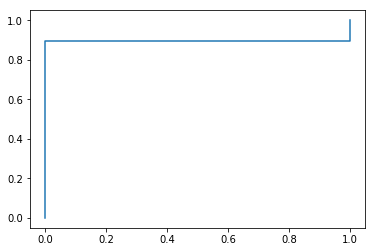

In [98]:
plt.plot(fpr, tpr)

(array([472.,  23.,  11.,  11.,  11.,   5.,   9.,   9.,  27., 422.]),
 array([-9.9984813e-01, -7.9986477e-01, -5.9988141e-01, -3.9989805e-01,
        -1.9991469e-01,  6.8664551e-05,  2.0005202e-01,  4.0003538e-01,
         6.0001874e-01,  8.0000210e-01,  9.9998546e-01], dtype=float32),
 <a list of 10 Patch objects>)

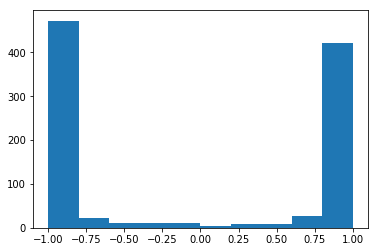

In [90]:
plt.hist(predict[:,0]-predict[:,1])

# Use models to evaluate dataset - using pass2

In [12]:
def rndgen():
    while True:
        rdata = np.random.randint(0, 256, (100,512), dtype='int')
        rdata = one_hot(rdata, 256)
        yield rdata

In [112]:
if os.path.exists(result_dir + "/evaluate2.tsv"):
    os.remove(result_dir + "/evaluate2.tsv")
r = Reporter2(result_dir + "/evaluate2.tsv")
by_category = rawset.by_category()
for cat, dataset in by_category.items():
    model1 = tf.keras.models.load_model(result_dir + '/%s_pass1.h5' % cat)
    tsampler = BlockSamplerByFile(dataset)
    tbenc = BatchEncoder(tsampler,
                         batch_size=1000,
                         xs_encoder='one_hot')
    xs, _ = next(iter(tbenc))
    datalen = len(xs)
    predict = model1.predict(xs, batch_size=100)
    predict = np.argmax(predict, axis=-1)

    
    if os.path.exists(result_dir + '/%s_pass2.h5' % cat):
        model2 = tf.keras.models.load_model(result_dir + '/%s_pass2.h5' % cat)
        xs = xs[predict==0]
        datalen = len(xs)
        predict = model2.predict(xs, batch_size=100)
        predict = np.argmax(predict, axis=-1)

    not_random = len(predict[predict==0])/datalen
    
    if os.path.exists(result_dir + '/%s_pass2.h5' % cat):
        predict = model2.predict_generator(rndgen(), steps=10)
    else:
        predict = model1.predict_generator(rndgen(), steps=10)
    predict = np.argmax(predict, axis=-1)   
    random = len(predict[predict==1])/(10*100)
    
    true_not_random = not_random - (1-not_random)*(1-random)/random
    
    print(cat, not_random, random, true_not_random )
    r.line(cat=cat, not_random=not_random, random=random, true_not_random=true_not_random)
r.close()

pptx 0.49619289340101524 0.983 0.4874800543245323
java 1.0 1.0 1.0
doc 0.9335476956055734 0.997 0.9333477388220395
csv 1.0 1.0 1.0
xml 0.999 1.0 0.999
wp 0.998 1.0 0.998
ps 0.98 1.0 0.98


KeyboardInterrupt: 

# Load evaluation data 2

In [ ]:
data4 = pd.read_csv(result_dir + "/evaluate2.tsv", sep='\t')
data4 = data4.sort_values('true_not_random')
data4

In [ ]:
from matplotlib.ticker import MultipleLocator
fig, ax = plt.subplots(figsize=(12,4))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
# plt.grid(linestyle='--', which='minor')
ax.bar(data4['cat'], data4['true_not_random'], fill=False)
plt.xticks(rotation='vertical')
ax.tick_params(labelsize=14)
for i in range(28):
    cat = rawset.ix_to_cat[i]
    v = data4.iloc[i,3]
    t = ax.annotate('%0.2f'%v, (i-0.3, v-0.06),fontsize=14)
    t.set_rotation(90)
# data3.plot.bar('cat', ['not_random'], figsize=(12,4))
# plt.show()

In [ ]:
data4.mean()

In [ ]:
1-np.sum(data4['true_not_random'])/28

In [ ]:
1-(np.sum(data4['true_not_random'])+(1-0.62))/28